In [1]:
import numpy as np
import h5py as h5
import seaborn as sns
import pandas as pd
import nengo
import nengo_spa as spa

In [2]:
hf = h5.File('/media/flo/LACIE_HD/structured_vocabs/rdarius_original/visual_output.h5', 'r')
hf1 = h5.File('/media/flo/LACIE_HD/structured_vocabs/gtsrb_data.h5', 'r')

In [3]:
keys = list(hf.keys())

In [4]:
d = {}
for k in keys:
    d[k] = np.array(hf[k])

In [5]:
list(hf1.keys())

['test_data', 'test_labels', 'train_data', 'train_labels']

In [6]:
d['test_labels'] = np.array(hf1['test_labels'])

In [7]:
d.keys()

dict_keys(['class_names', 'confidence', 'prediction', 'visual_vectors', 'test_labels'])

In [8]:
mask = d['prediction'] == d['test_labels']

In [9]:
np.where(~mask)[0]

array([   39,    50,   114,   127,   176,   339,   374,   421,   459,
         461,   492,   537,   550,   806,   951,  1079,  1200,  1317,
        1352,  1462,  1475,  1489,  1524,  1560,  1583,  1597,  1689,
        1745,  1759,  1763,  1774,  1898,  1910,  1918,  2002,  2017,
        2076,  2109,  2154,  2258,  2332,  2370,  2376,  2388,  2482,
        2494,  2577,  2682,  2751,  2776,  2836,  2886,  2980,  3052,
        3086,  3137,  3523,  3564,  3593,  3660,  3704,  3727,  3744,
        3778,  3819,  3860,  3930,  3960,  4011,  4072,  4115,  4147,
        4185,  4219,  4271,  4314,  4316,  4341,  4383,  4443,  4601,
        4617,  4634,  4702,  4739,  4783,  4953,  4983,  5182,  5476,
        5507,  5518,  5521,  5529,  5547,  5625,  5637,  5641,  5675,
        5924,  6028,  6087,  6090,  6129,  6155,  6177,  6213,  6220,
        6255,  6310,  6321,  6334,  6356,  6418,  6469,  6600,  6613,
        6731,  6739,  6782,  6874,  6889,  6893,  6920,  6941,  6960,
        6980,  6991,

In [10]:
ind_list = []
for c in np.arange(43):
    inds = np.where(d['test_labels'] == c)[0]
    correct_inds = np.where(d['prediction'][inds] == d['test_labels'][inds])[0]
    high_conf_inds = np.where(d['confidence'][inds][correct_inds] == 1.0)[0]
    final = inds[correct_inds][high_conf_inds]
    ind_list.append(final)

In [11]:
hf2 = h5.File('/media/flo/LACIE_HD/structured_vocabs/rdarius_original/traffic_sign_complete_vocab.h5', 'r')

In [12]:
vocab = spa.Vocabulary(dimensions=300)

In [13]:
vecs = np.array(hf2['visual_vocab_vectors'])

In [14]:
for i in np.arange(43):
    vocab.add(key=str(d['class_names'][i].decode()), p=vecs[i])

In [15]:
data = []
for i in np.arange(43):
    vis_vecs = d['visual_vectors'][ind_list[i]]
    for j, vec in enumerate(vis_vecs):
        dic = dict(sign=i,
                   similarity=vocab[str(d['class_names'][i].decode())].compare(spa.SemanticPointer(vec)))
        data.append(dic)
df = pd.DataFrame(data)

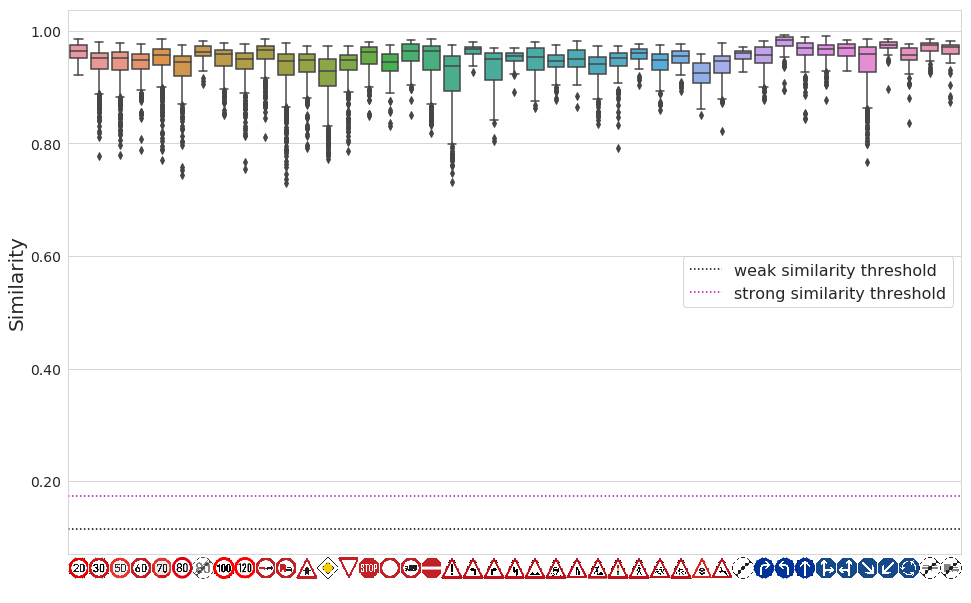

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
fig = plt.figure(figsize=(16,10))
sns.set_style("whitegrid")
ax = sns.boxplot(x='sign', y='similarity', data=df)
ax.axhline(2./np.sqrt(300), c='k', ls=':', label='weak similarity threshold')
ax.axhline(3./np.sqrt(300), c='m', ls=':', label='strong similarity threshold')
# replace x-ticks with corresponding imgs
size=0.03
xl, yl, xh, yh=np.array(ax.get_position()).ravel()
xl+= 0.003
xh-= size
w=xh-0.095
h=yh-yl
ax.set_xticklabels(['']*43, fontsize=14)
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_ylabel('Similarity', fontsize=20)
# ax.grid(ls=':', alpha=0.5, c='k')
for ind in np.arange(43):
    
    img=plt.imread('../imgs//TrafficSigns/%s.png'%(str(ind).zfill(2)))
    xp=xl+w*((ind)/43) #if replace '0' label, can also be calculated systematically using xlim()
    yp=yl-size*0.5-0.02
    # ax.bar(np.arange(43), acc)
    ax1=fig.add_axes([xp-size*0.3, yp, size, size])
    ax1.axison = False
    imgplot = ax1.imshow(img)
ax.legend(loc='best', fontsize=16)
plt.savefig('/home/flo/git/diss/thesis/imgs/Visual_vocab_traffic_signs_similarity_with_representative_vecs.eps', dpi=1200)
plt.show()

In [17]:
sims = np.zeros((43,43))
mask = np.zeros((43,43))
for i in np.arange(43):
    for j in np.arange(43):
        sims[i,j] = vocab[str(d['class_names'][i].decode())].compare(vocab[str(d['class_names'][j].decode())])
#         if j >= i:
#             mask = True

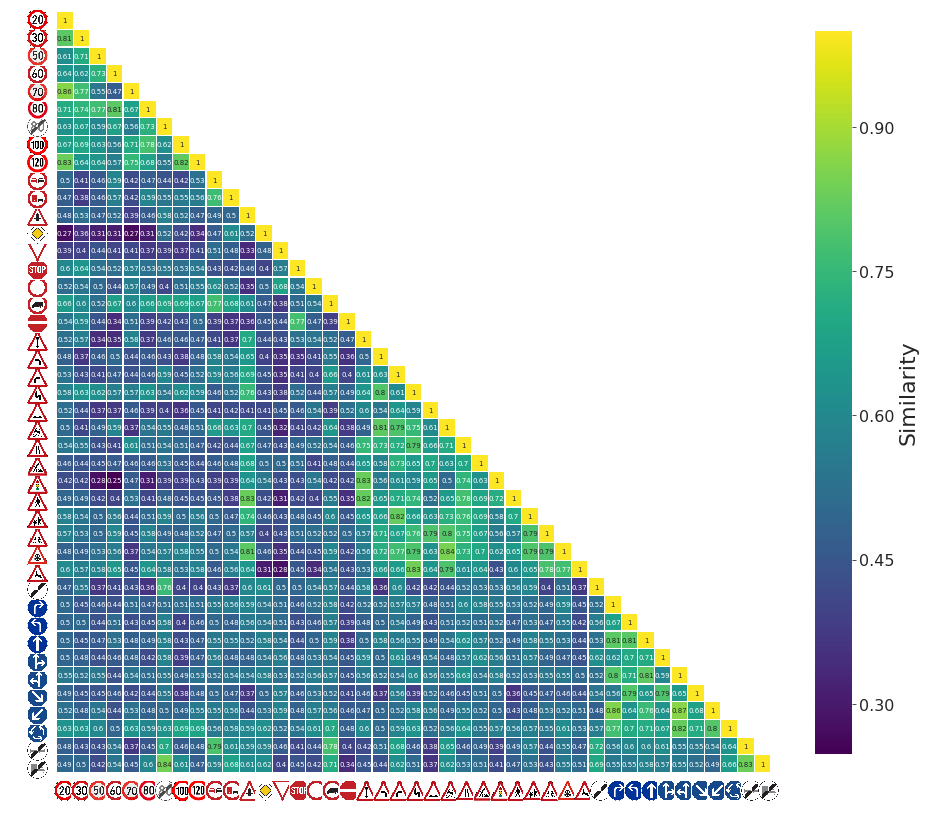

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib import cm
mask = np.zeros_like(sims)
mask[np.triu_indices_from(mask, k=1)] = True
fig = plt.figure(figsize=(16,14))
ax = sns.heatmap(sims, mask=mask, annot=True, annot_kws={"size": 7}, 
                 cmap=cm.viridis, linewidths=0.2, 
                 cbar_kws={"label": "Similarity", "shrink":0.95})
ax.figure.axes[-1].yaxis.label.set_size(22)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=16)
ax.set_xticklabels(['']*43, fontsize=14)
ax.set_yticklabels(['']*43, fontsize=14)
size=0.02
xl, yl, xh, yh=np.array(ax.get_position()).ravel()
xl+= 0.003
xh-= size
w=xh-0.1
h=yh-0.12
for ind in np.arange(43):
    img=plt.imread('../imgs//TrafficSigns/%s.png'%(str(ind).zfill(2)))
    img2=plt.imread('../imgs//TrafficSigns/%s.png'%(str(42-ind).zfill(2)))
    xp=xl+w*((ind)/43) #if replace '0' label, can also be calculated systematically using xlim()
    yp=yl-size*0.4-0.02
    # ax.bar(np.arange(43), acc)
    ax1=fig.add_axes([xp-size*0.3, yp, size, size])
    ax1.axison = False
    xp=xl-size-0.01
    yp=yl+h*((ind)/43)
    ax2=fig.add_axes([xp, yp-size*0.3, size, size])
    ax2.axison = False
    imgplot = ax1.imshow(img)
    imgplot2 = ax2.imshow(img2)
plt.savefig('/home/flo/git/diss/thesis/imgs/visual_vocab_traffic_signs_internal_similarities.eps', dpi=1200)
plt.show()